# Final Project Script
### Los Niños



The number and magnitude of natural disasters declared as federal emergencies in
the United States during the past few years has increased precipitously. One
estimate puts the amount of federal funds spent on natural disasters by the Federal
Emergency Management Agency (FEMA) during the two years, from 2017 to 2019,
to exceed that of the amount of federal funds spent on all national disasters during
the prior 38 years, since FEMA’s inception in 1979.

A majority of large, costly, natural disasters involve rainfall and flooding. Currently,
there is no known federal system or process that links real-time weather data to
predict which areas will be included in a disaster declaration or to estimate the
magnitude of a disaster using data science.

When a hurricane or severe storm causes damage, detailed knowledge of the
magnitude of damage and which areas are most impacted may not be known for several hours to days later.  As can happen, severe storms can damage weather collection devices, such as rain gauges, causing ‘black-outs’ of important weather information just as the most severe weather hits an area.

Planning and allocating emergency resources at the federal level
are sometimes made without full information on the immediate rainfall impacting a geographic area, or the extent of damage caused by a disaster at the time of a disaster.

Here in lies an opportunity to use real-time and future weather data and data science to create
predictive models that predict which areas will be included in a disaster declaration
and the magnitude of damage. Accurate, real-time predictions will give emergency
managers additional hours and days to better allocate emergency resources at the
offset of a disaster, providing better emergency assistance to the American people.


In [1]:
import time
import geopandas
import shapely
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpt
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.naive_bayes import GaussianNB
from yellowbrick.classifier import ClassificationReport
from yellowbrick.datasets import load_occupancy
from yellowbrick.classifier import PrecisionRecallCurve
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
from matplotlib import cm
from yellowbrick.datasets import load_credit
from yellowbrick.features import Rank2D
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.datasets import load_credit
from yellowbrick.features import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

/Users/lucasvalentich/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/lucasvalentich/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Import datasets

In [2]:
FEMA = pd.read_csv(r"/Users/lucasvalentich/Desktop/Brian_Jupyter_notebook/FEMA.csv")

In [3]:
NASA = pd.read_csv(r"/Users/lucasvalentich/Desktop/Brian_Jupyter_notebook/NASAFEMAData81220.csv")

/Users/lucasvalentich/.pyenv/versions/3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (20,21,24,35,43,44,46,47,48,49,50,51) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Clean NASA dataset

In [4]:
#split geometry into lat and lon for modeling
gdf = geopandas.GeoDataFrame(NASA)

In [5]:
gdf.geometry2 = gdf.geometry
gdf.geometry2 = gdf.geometry2.astype(str)
gdf.geometry2 = gdf.geometry2.map(lambda x: x.lstrip('POINT  (').rstrip(')'))

/Users/lucasvalentich/.pyenv/versions/3.7.3/lib/python3.7/site-packages/geopandas/geodataframe.py:167: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)


In [6]:
# Create two lists for the loop results to be placed
lat = []
lon = []

# For each row in a varible,
for row in gdf.geometry2:
    # Try to,
    try:
        # Split the row by comma and append
        # everything before the comma to lat
        lat.append(row.split(' ')[1])
        # Split the row by comma and append
        # everything after the comma to lon
        lon.append(row.split(' ')[0])
    # But if you get an error
    except:
        # append a missing value to lat
        lat.append(np.NaN)
        # append a missing value to lon
        lon.append(np.NaN)

# Create two new columns from lat and lon
gdf['latitude'] = lat
gdf['longitude'] = lon

In [7]:
#converts NASA Time(numeric value) back to date
NASA = gdf
NASA['Date'] = pd.to_datetime(NASA['Time'], unit='D')

In [8]:
#Create column of the month the precipitation happened
NASA['Month'] = NASA['Date'].dt.month

In [9]:
#creates key to link NASA data with FEMA data
NASA['FEMAkey'] = NASA['COUNTYFP'].astype('str') + '-' + NASA['Time'].astype('str')

# Clean FEMA dataset

In [10]:
#removes non-water related disasters.  This code also moved to FEMA data prep.
incTypes = ['Hurricane', 'Severe Storm(s)', 'Coastal Storm']
FEMA = FEMA[FEMA.incidentType.isin(incTypes)]

In [11]:
#creates binary variable for modeling - Disaster Yer/No
FEMA['DR_YN'] = (FEMA['disasterNumber'] > 1)

In [12]:
#This is code also belongs in the FEMA data section
incidentbegin = FEMA[['IncidentBeginDatekey']]

In [13]:
#create new variable for declaration data and incident begin data to include DR number + text
FEMA['DR'] = 'DR' + '-' + FEMA['disasterNumber'].astype('str')
FEMA['IBD'] = 'IBD' + '-' + FEMA['disasterNumber'].astype('str')

# Merge NASA and FEMA datasets

In [14]:
#Merge Nasa and Fema data
Merge2 = pd.merge(NASA, FEMA, left_on="FEMAkey", right_on='DecDateKey', how='left')

In [15]:
Merge3 = pd.merge(Merge2, incidentbegin, left_on="FEMAkey", right_on='IncidentBeginDatekey', how='left')

# Fit dataframe for models

In [16]:
#Select the columns that we need for the analysis
NASAset = Merge3[['Time', 'DR', 'Month', 'latitude', 'longitude', 'DR_YN', 'geometry', 'NAME', 'FEMAkey', 'Precip']]

In [17]:
#Creates 21 days of precipitation as features for each day
NASAset['day_1_Precip'] = NASAset.groupby('geometry')['Precip'].shift(-1)
NASAset['day_2_Precip'] = NASAset.groupby('geometry')['Precip'].shift(-2)
NASAset['day_3_Precip'] = NASAset.groupby('geometry')['Precip'].shift(-3)
NASAset['day_4_Precip'] = NASAset.groupby('geometry')['Precip'].shift(-4)
NASAset['day_5_Precip'] = NASAset.groupby('geometry')['Precip'].shift(-5)
NASAset['day_6_Precip'] = NASAset.groupby('geometry')['Precip'].shift(-6)
NASAset['day_7_Precip'] = NASAset.groupby('geometry')['Precip'].shift(-7)
NASAset['day_8_Precip'] = NASAset.groupby('geometry')['Precip'].shift(-8)
NASAset['day_9_Precip'] = NASAset.groupby('geometry')['Precip'].shift(-9)
NASAset['day_10_Precip'] = NASAset.groupby('geometry')['Precip'].shift(-10)
NASAset['day_11_Precip'] = NASAset.groupby('geometry')['Precip'].shift(-11)
NASAset['day_12_Precip'] = NASAset.groupby('geometry')['Precip'].shift(-12)
NASAset['day_13_Precip'] = NASAset.groupby('geometry')['Precip'].shift(-13)
NASAset['day_14_Precip'] = NASAset.groupby('geometry')['Precip'].shift(-14)
NASAset['day_15_Precip'] = NASAset.groupby('geometry')['Precip'].shift(-15)
NASAset['day_16_Precip'] = NASAset.groupby('geometry')['Precip'].shift(-16)
NASAset['day_17_Precip'] = NASAset.groupby('geometry')['Precip'].shift(-17)
NASAset['day_18_Precip'] = NASAset.groupby('geometry')['Precip'].shift(-18)
NASAset['day_19_Precip'] = NASAset.groupby('geometry')['Precip'].shift(-19)
NASAset['day_20_Precip'] = NASAset.groupby('geometry')['Precip'].shift(-20)
NASAset['day_21_Precip'] = NASAset.groupby('geometry')['Precip'].shift(-21)

/Users/lucasvalentich/.pyenv/versions/3.7.3/lib/python3.7/site-packages/geopandas/geodataframe.py:831: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [18]:
#Fill N/A values with 0
NASAset = NASAset.fillna(0)
NASAset['DR_YN'] = NASAset['DR_YN'].astype(int)

In [19]:
NASAset.shape

(9955464, 31)

##### Create subdataframe to work with less data

In [96]:
#crete subdataframe of days in which a disaster was not declared.
NASAsetsubF = NASAset[NASAset.DR_YN == False]
#crete subdataframe of days in which a disaster was declared.
NASAsetsubT = NASAset[NASAset.DR_YN == True]

In [97]:
#randome sample with replacement of non-disaster days, around 3X the number of disasters
NASAsetsubF = NASAsetsubF.sample(100000)

In [98]:
#concatanates dataframes to create full dataframe for modeling
NASAsetM = pd.concat([NASAsetsubF, NASAsetsubT])

In [99]:
#New shape
NASAsetM.shape

(112846, 31)

##### Transform counties names into numbers for analysis

In [100]:
LE = LabelEncoder()
NASAsetM['NAME_code'] = LE.fit_transform(NASAsetM['NAME'])

# Data analysis

In [101]:
def plot_classification_report(cr, title='Classification report', cmap=plt.cm.Reds):

    lines = cr.split('\n')
    classes = []
    plotMat = []

    for line in lines[2 : (len(lines) - 5)]:
        t = line.split()
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        plotMat.append(v)

    fig, ax = plt.subplots(figsize=(10,5))
    fig = plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    
    for c in range(len(plotMat)+1):
        for r in range(len(classes)):
            try:
                txt = plotMat[r][c]
                ax.text(c,r,plotMat[r][c],va='center',ha='center')
            except IndexError:
                pass
            
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes)-1)
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
        
    plt.yticks(y_tick_marks, classes)
   
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')

In [102]:
feature_names = ['Month', 'day_1_Precip',
       'day_2_Precip', 'day_3_Precip', 'day_4_Precip', 'day_5_Precip',
       'day_6_Precip', 'day_7_Precip']
X = NASAsetM[feature_names]
y = NASAsetM['DR_YN']
cmap = cm.get_cmap('gnuplot')
scatter = scatter_matrix(X, c = y, marker = 'o', s=40, hist_kwds={'bins':15}, figsize=(15,15), cmap = cmap)

AttributeError: 'DecisionTreeClassifier' object has no attribute 'get_cmap'

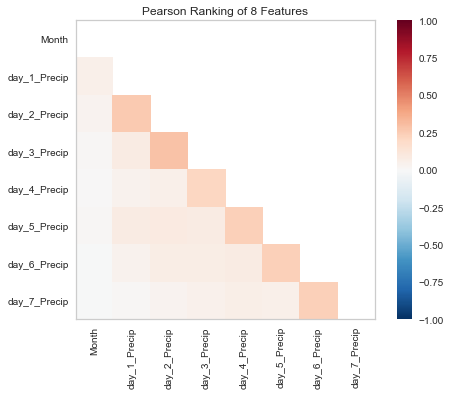

<AxesSubplot:title={'center':'Pearson Ranking of 8 Features'}>

In [103]:
# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='pearson')

visualizer.fit(X, y)           # Fit the data to the visualizer
visualizer.transform(X)        # Transform the data
visualizer.show()              # Finalize and render the figure

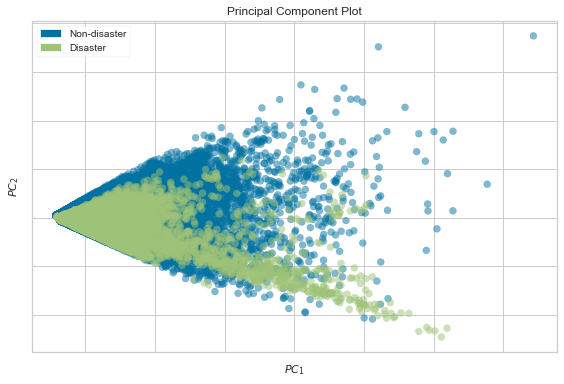

<AxesSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [104]:
classes = ['Non-disaster','Disaster']

visualizer = PCA(scale=True, classes=classes, alpha = 0.5)
visualizer.fit_transform(X, y)
visualizer.show()

##### Select different sets of features for modeling.  We find 'feature_cols3' works best.

In [107]:
feature_colsall = []
feature_cols = ['day_1_Precip',
       'day_2_Precip', 'day_3_Precip', 'day_4_Precip', 'day_5_Precip',
       'day_6_Precip', 'day_7_Precip', 'day_8_Precip', 'day_9_Precip',
       'day_10_Precip', 'day_11_Precip', 'day_12_Precip', 'day_13_Precip']
feature_cols1 = ['Month', 'latitude', 'longitude', 'day_1_Precip',
       'day_2_Precip', 'day_3_Precip', 'day_4_Precip', 'day_5_Precip',
       'day_6_Precip', 'day_7_Precip', 'day_8_Precip', 'day_9_Precip',
       'day_10_Precip', 'day_11_Precip', 'day_12_Precip', 'day_13_Precip',
       'day_14_Precip', 'day_15_Precip', 'day_16_Precip', 'day_17_Precip',
       'day_18_Precip', 'day_19_Precip', 'day_20_Precip', 'day_21_Precip']
feature_cols2 = ['Time', 'latitude', 'longitude', 'day_1_Precip',
       'day_2_Precip', 'day_3_Precip', 'day_4_Precip', 'day_5_Precip',
       'day_6_Precip', 'day_7_Precip']
feature_cols3 = ['Month','latitude', 'longitude', 'day_1_Precip',
       'day_2_Precip', 'day_3_Precip', 'day_4_Precip', 'day_5_Precip',
       'day_6_Precip', 'day_7_Precip']

# Prepare for modeling 

##### Divide data into X and y for machine learning modules

In [108]:
X = NASAsetM[feature_cols3]
y = NASAsetM.DR_YN

##### Split data into training and testing

In [109]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.25,random_state=0)

# Models

### RandomForest

In [110]:
forest = RandomForestClassifier(random_state=0, n_estimators=3, max_depth=12)
forest.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

expected   = y_test
predicted  = forest.predict(X_test)
classificationReport = classification_report(expected, predicted, target_names=["Non-disaster", "Disaster"])
print(classificationReport)

Accuracy on training set: 0.943
Accuracy on test set: 0.931
              precision    recall  f1-score   support

Non-disaster       0.94      0.99      0.96     24935
    Disaster       0.85      0.50      0.63      3277

    accuracy                           0.93     28212
   macro avg       0.89      0.74      0.79     28212
weighted avg       0.93      0.93      0.92     28212



In [111]:
#Features importance for RandomForest
print("Feature importances:\n{}".format(forest.feature_importances_))

Feature importances:
[0.33881945 0.06226348 0.06591878 0.15589956 0.08932383 0.06110581
 0.04263495 0.04896681 0.0653263  0.06974103]


Features importances for RandomForest

/Users/lucasvalentich/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


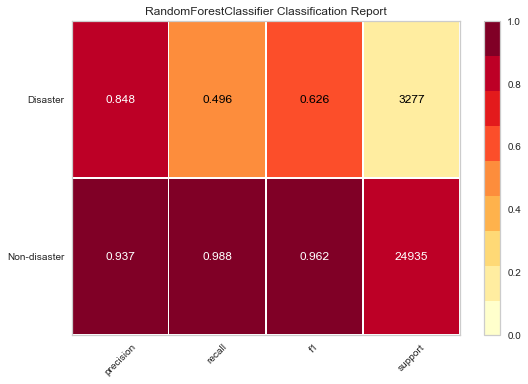

<AxesSubplot:title={'center':'RandomForestClassifier Classification Report'}>

In [112]:
classes = ["Non-disaster", "Disaster"]
visualizer = ClassificationReport(forest, classes=classes, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

/Users/lucasvalentich/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


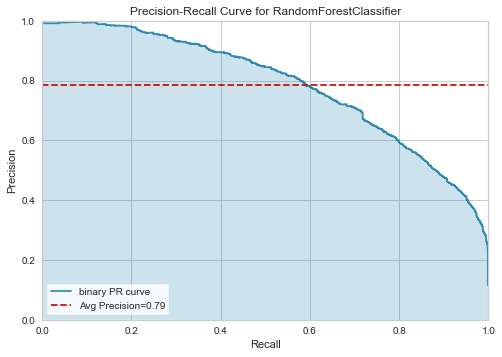

<AxesSubplot:title={'center':'Precision-Recall Curve for RandomForestClassifier'}, xlabel='Recall', ylabel='Precision'>

In [113]:
viz = PrecisionRecallCurve(forest)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

/Users/lucasvalentich/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


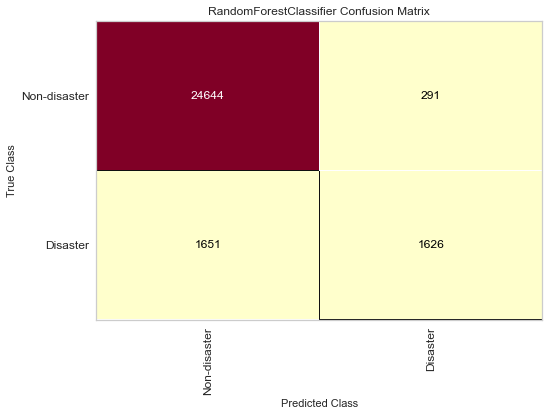

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [114]:
cm = ConfusionMatrix(forest, classes=['Non-disaster','Disaster'])
# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)
# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)
# How did we do?
cm.show()

### DecisionTree

In [115]:
clf = DecisionTreeClassifier(max_depth=12, class_weight="balanced").fit(X_train, y_train)
y_pred=clf.predict(X_test)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))

expected   = y_test
predicted  = clf.predict(X_test)
classificationReport = classification_report(expected, predicted, target_names=["Non-disaster", "Disaster"])
print(classificationReport)

Accuracy of Decision Tree classifier on training set: 0.85
Accuracy of Decision Tree classifier on test set: 0.84
              precision    recall  f1-score   support

Non-disaster       0.99      0.82      0.90     24935
    Disaster       0.41      0.95      0.57      3277

    accuracy                           0.84     28212
   macro avg       0.70      0.88      0.74     28212
weighted avg       0.92      0.84      0.86     28212



In [116]:
#Features importance for DecisionTree
print("Feature importances:\n{}".format(clf.feature_importances_))

Feature importances:
[0.5884876  0.04132384 0.05894864 0.08062692 0.0517396  0.02974778
 0.02212291 0.04141735 0.03687849 0.04870686]


/Users/lucasvalentich/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


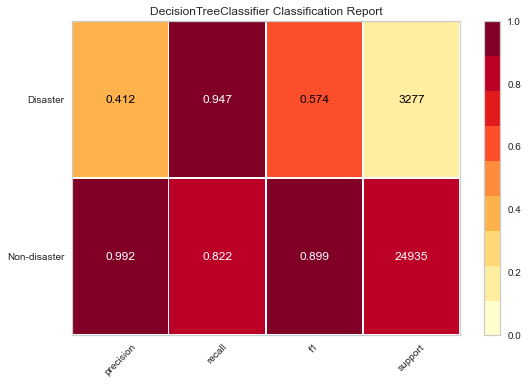

<AxesSubplot:title={'center':'DecisionTreeClassifier Classification Report'}>

In [117]:
classes = ["Non-disaster", "Disaster"]
visualizer = ClassificationReport(clf, classes=classes, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

/Users/lucasvalentich/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


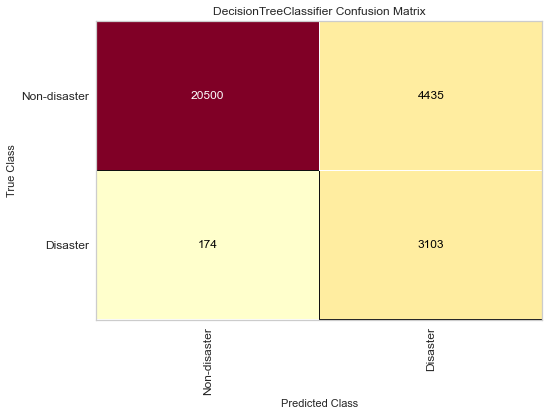

<AxesSubplot:title={'center':'DecisionTreeClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [118]:
cm = ConfusionMatrix(clf, classes=['Non-disaster','Disaster'])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()

### LogisticRegression

In [119]:
logreg = LogisticRegression(class_weight="balanced")
logreg.fit(X_train, y_train)
y_pred=logreg.predict(X_test)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))
expected   = y_test
predicted  = logreg.predict(X_test)
classificationReport = classification_report(expected, predicted, target_names=["Non-disaster", "Disaster"])
print(classificationReport)

Accuracy of Logistic regression classifier on training set: 0.63
Accuracy of Logistic regression classifier on test set: 0.63
              precision    recall  f1-score   support

Non-disaster       0.94      0.63      0.75     24935
    Disaster       0.20      0.70      0.31      3277

    accuracy                           0.63     28212
   macro avg       0.57      0.66      0.53     28212
weighted avg       0.85      0.63      0.70     28212



/Users/lucasvalentich/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


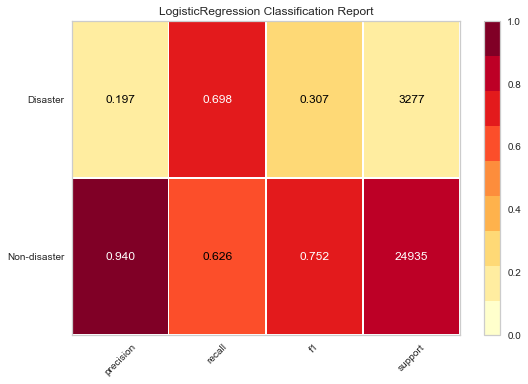

<AxesSubplot:title={'center':'LogisticRegression Classification Report'}>

In [120]:
classes = ["Non-disaster", "Disaster"]
visualizer = ClassificationReport(logreg, classes=classes, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

/Users/lucasvalentich/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


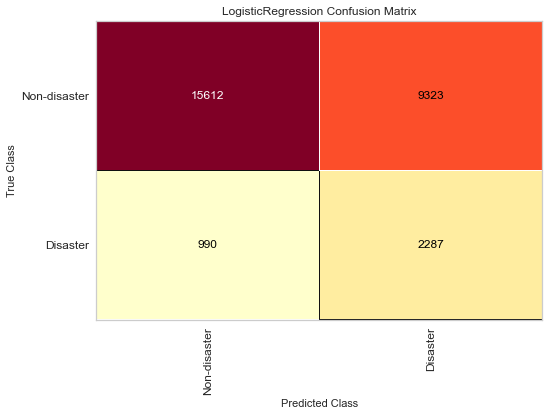

<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [121]:
cm = ConfusionMatrix(logreg, classes=['Non-disaster','Disaster'])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()

# Cross Validation

### DecisionTree

In [122]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X, y, cv = 6)
print(scores)
print("Accuracy of Model with Cross Validation is:",scores.mean() * 100)

[0.81981072 0.81475968 0.80226499 0.82289451 0.81926942 0.82070506]
Accuracy of Model with Cross Validation is: 81.6617396626237


In [123]:
from sklearn.model_selection import ShuffleSplit
shuffle_split = ShuffleSplit(test_size=.5, train_size=.5, n_splits=10) 
scores = cross_val_score(clf, X, y, cv=shuffle_split) 
print("Cross-validation scores:\n{}".format(scores))
print("Accuracy of Model with Cross Validation is:",scores.mean() * 100)

Cross-validation scores:
[0.84476189 0.85353491 0.84789891 0.87143541 0.84360988 0.84938766
 0.86308775 0.8533045  0.83497864 0.84674689]
Accuracy of Model with Cross Validation is: 85.08746433192137


In [124]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True) 
scores = cross_val_score(clf, X, y, cv=kfold)
print(scores)
print("Accuracy of Model with Cross Validation is:",scores.mean() * 100)
print('Accuracy of DecisionTree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

[0.84089499 0.86091541 0.84815455 0.84921795 0.85010413]
Accuracy of Model with Cross Validation is: 84.98574071071528
Accuracy of DecisionTree classifier on training set: 0.85


### RandomForest

In [125]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(forest, X, y, cv=5)
print(scores)
print("Accuracy of Model with Cross Validation is:",scores.mean() * 100)

[0.87713779 0.89556471 0.88745625 0.88032257 0.90779388]
Accuracy of Model with Cross Validation is: 88.96550388781644


In [126]:
from sklearn.model_selection import ShuffleSplit
shuffle_split = ShuffleSplit(test_size=.5, train_size=.5, n_splits=10) 
scores = cross_val_score(forest, X, y, cv=shuffle_split) 
print("Cross-validation scores:\n{}".format(scores))
print("Accuracy of Model with Cross Validation is:",scores.mean() * 100)

Cross-validation scores:
[0.93279336 0.92588129 0.93399855 0.92997536 0.92955001 0.92838027
 0.93116282 0.93180086 0.93169452 0.93139323]
Accuracy of Model with Cross Validation is: 93.066302748879


In [127]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True) 
scores = cross_val_score(forest, X, y, cv=kfold)
print(scores)
print("Accuracy of Model with Cross Validation is:",scores.mean() * 100)
print('Accuracy of RandomForest classifier on training set: {:.2f}'
     .format(forest.score(X_train, y_train)))

[0.93296411 0.93384731 0.93526519 0.93300545 0.93034694]
Accuracy of Model with Cross Validation is: 93.30857994229993
Accuracy of RandomForest classifier on training set: 0.94


In [128]:
import pickle

In [129]:
filename = 'finalized_model.sav'
pickle.dump(clf, open(filename, 'wb'))